In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import os
#Creates folder data if it doesn't exit
os.makedirs(os.path.dirname("./data"), exist_ok=True)

# Crawler
Starting from a website crawls all the outgoing links, looking for a word/sentence and saving the results

In [ ]:
from time import sleep
from random import random
from urllib.parse import urljoin

def get_links_website(website,keyword_search):
    """
    Finds all the links in the website, and how many times the keyword was found
    """
    try: r = requests.get(website, timeout=100)
    except: return 0,[]
    if r.ok:
        html = bs.BeautifulSoup(r.text, "lxml")
    else: 
        print(r.status_code)
        return 0,[]
    
    #Find all snapshots
    snapshots = []
    all_links = html.find_all("a", href=True)
    hits = r.text.count(keyword_search)
    return hits,all_links

def crawl_one_level(snapshot, link_base, links_snapshot_set,keyword):
    """
    get's the links of the website (link_base) and filter them, keeping the ones that stay in the domain
    """
    hits, links = get_links_website(link_base,keyword)
    for link in links:
        link_joined = urljoin(link_base, link["href"])
        if (snapshot in link_joined) and (link_joined not in links_snapshot_set):
            links_snapshot_set.add(link_joined)
    return hits, links_snapshot_set


def crawl_all_levels(snapshot,keyword):
    """
    crawls the website snapshot, without leaving the domain
    """
    #Get source code
    dict_hits = dict()
    links_snapshot_set_old = set([snapshot])
    new_links = set([snapshot])
    while len(new_links) > 0:
        for i, link in enumerate(new_links):
            sleep(random()*2)            
            hits, links_snapshot_set_new = crawl_one_level(snapshot, link,links_snapshot_set_old.copy(),keyword)
            print("{0}: Link: {1} has the word \"{2}\" {3} times".format(i, link,keyword,hits))
            dict_hits.update({link: hits})
        new_links = links_snapshot_set_new - links_snapshot_set_old
        print("\nNew links to follow: ", len(new_links))
        links_snapshot_set_old = links_snapshot_set_old | links_snapshot_set_new
        
    return dict_hits

def BFS_keyword(website,keyword,filename):
    """
    calls the script and saves the results to a file
    """
    dict_hits = crawl_all_levels(website,keyword)
    
    with open(filename, "w+") as f:
        f.write("link" + "\t" + "number_hits" + "\n")
        for link in dict_hits:
            f.write(link + "\t" + dict_hits[link] + "\n")

##USAGE
initial_website = "https://www.amnesty.org/en/"
words_to_find = "campaign"
file_to_save = "results_crawling_amnesty.csv"
BFS_keyword(initial_website,words_to_find,file_to_save)

# LEXIS NEXIS Crawler
Queries a search in lexis nexis, using the CSI (http://www.lexisnexis.com/hottopics/lnacademic/) as the newspaper identifier

Disclaimer: We accept no liability for the content of this code, or for the consequences of any actions taken on the basis of the information provided.

Code from: http://yc-lexisnexis-scraper.readthedocs.org/

In [ ]:
import random
import re
import os
import requests
import urllib.request, urllib.parse, urllib.error
import urllib.parse as urlparse

import selenium.common.exceptions
import selenium.webdriver
import selenium.webdriver.common.desired_capabilities
import selenium.webdriver.support.ui
from selenium.webdriver.support import expected_conditions


class LexisNexisScraper():
    """
    Class for downloading documents given a query string to Lexis Nexis academic (http://www.lexisnexis.com/hottopics/lnacademic/).

    Example::

            downloader = LexisNexisScraper(mass_download_mode=True)
            for (content, (doc_index, doc_count)) in downloader.iter_search_results(6318, 'DATE(=1987)'):
                print doc_id

     """

    _RE_STYLESHEET = re.compile(r'\<STYLE TYPE\=\"text\/css\"\>(\<\!\-\-)?(?P<css_string>.+?)(\-\-\>)?\<\/STYLE\>', flags=re.S | re.U | re.I)
    _RE_LEXIS_DOC = re.compile(r'\<DOC NUMBER\=(?P<docid>\d+)\>\s+\<DOCFULL\>(?P<doc>.+?)\<\/DOCFULL\>', flags=re.S | re.U | re.I)

    def __init__(self, wait_timeouts=(15, 180), documents_per_download=(250, 500), user_agent_string='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:25.0) Gecko/20100101 Firefox/25.0', mass_download_mode=False):
        """
        Constructs a downloader object.

        :param float,float wait_timeouts: tuple of `(short, long)` where `short` and `long` are the no. of seconds to wait while page elements are loaded (for Webdriver). `long` timeout is used when waiting for LexisNexis to format documents for mass downloads.
        :param int,int documents_per_download: a range specifying the number of documents to download each time when using :attr:`mass_download_mode`.
        :param bool mass_download_mode: whether to mass download articles using the download link or page through each document one by one and download.
        """

        self._USER_AGENT_STRING = user_agent_string
        self._DOCUMENTS_PER_DOWNLOAD = documents_per_download

  
        self._driver = selenium.webdriver.Firefox()
        self._driver.set_window_size(800, 600)

        self._short_wait = selenium.webdriver.support.ui.WebDriverWait(self._driver, wait_timeouts[0], poll_frequency=0.05)
        self._long_wait = selenium.webdriver.support.ui.WebDriverWait(self._driver, wait_timeouts[1], poll_frequency=1)

        self.mass_download_mode_ = mass_download_mode
    #end def

    def __del__(self):
        try: self._driver.quit()
        except: pass

    def iter_search_results(self, csi, search_query, start_from=1):
        """
        A generator function that executes LexisNexis search query on source data CSI (:attr:`csi`), with query :attr:`search_query` and downloads all documents returned by search.

        :param str csi: LexisNexis CSI (see `<http://amdev.net/rpt_download.php>`_ for full list).
        :param str search_query: execute search query string.
        :param int start_from: document index to start downloading from.
        :returns: a tuple `(doc_content, (index, results_count))`, where `doc_content` is the HTML content of the `index`th document, and `results_count` is the number of documents returned by specified search query.
        """

        self._driver.get('http://www.lexisnexis.com/hottopics/lnacademic/?' + urllib.parse.urlencode({'verb': 'sr', 'csi': csi, 'sr': search_query}))
        if not self._have_results(): return []

        if self.mass_download_mode_: return self._mass_download(start_from)
        return self._sequential_download(start_from)
    #end def

    def _have_results(self):    # todo: kinda slow, due to having wait for multiple timeouts
        self._switch_to_frame('main')
        if self._wait_for_element('//td[text()[contains(., \'No Documents Found\')]]', raise_error=False) is not None: return False
        if self._wait_for_element('//frame[@title=\'Results Content Frame\']', raise_error=False) is not None: return True
        if self._wait_for_element('//frame[@title=\'Results Document Content Frame\']', raise_error=False) is not None: return True

        raise Exception('Page loaded improperly while checking for results frame.')
    #end def

    def _mass_download(self, start_from=1):    # Returns documents as a list of strings containing HTML
        self._switch_to_frame('navigation')

        try: documents_count = int(self._driver.find_element_by_xpath('//form[@name=\'results_docview_DocumentForm\']/input[@name=\'totalDocsInResult\']').get_attribute('value'))
        except: documents_count = -1

        def download_sequence(start, end):
            docs_left = end - start + 1
            cur = start
            while docs_left > self._DOCUMENTS_PER_DOWNLOAD[1]:
                download_count = random.randint(*self._DOCUMENTS_PER_DOWNLOAD)
                yield (cur, cur + download_count - 1)
                docs_left -= download_count
                cur += download_count
            #end while

            yield (cur, cur + docs_left - 1)
        #end def

        def lexis_nexis_download_window_appears(current_handle):
            def f(driver):
                for handle in driver.window_handles:
                    if current_handle != handle:
                        driver.switch_to.window(handle)    # switch first to check window title
                        if driver.title.endswith('Download Documents'): return True    # this is our new window!
                    #end if
                #end for

                return False
            #end def

            return f
        #end class

        for download_start, download_end in download_sequence(start_from, documents_count):
            self._switch_to_frame('navigation')

            parent_window_handle = self._driver.current_window_handle

            # check for download icon and click it
            self._wait_for_element('//img[@title=\'Download Documents\']').click()

            # wait for download window to appear
            self._short_wait.until(lexis_nexis_download_window_appears(parent_window_handle))
            self._wait_for_element('//img[@title=\'Download\']')

            # get all the form items
            selenium.webdriver.support.ui.Select(self._driver.find_element_by_xpath('//select[@name=\'delFmt\']')).select_by_value('QDS_EF_HTML')
            selenium.webdriver.support.ui.Select(self._driver.find_element_by_xpath('//select[@name=\'delView\']')).select_by_value('GNBFI')
            selenium.webdriver.support.ui.Select(self._driver.find_element_by_xpath('//select[@name=\'delFontType\']')).select_by_value('COURIER')    # i like courier

            search_term_bold = self._driver.find_element_by_xpath('//input[@type=\'checkbox\'][@id=\'termBold\']')
            if not search_term_bold.is_selected(): search_term_bold.click()
            doc_new_page = self._driver.find_element_by_xpath('//input[@type=\'checkbox\'][@id=\'docnewpg\']')
            if not doc_new_page.is_selected(): doc_new_page.click()

            self._driver.find_element_by_xpath('//input[@type=\'radio\'][@id=\'sel\']').click()
            self._driver.find_element_by_xpath('//input[@type=\'text\'][@id=\'rangetextbox\']').send_keys('{}-{}'.format(download_start, download_end))

            self._driver.find_element_by_xpath('//img[@title=\'Download\']').click()

            download_url = self._long_wait.until(expected_conditions.presence_of_element_located((selenium.webdriver.common.by.By.XPATH, '//center[@class=\'suspendbox\']/p/a'))).get_attribute('href')

            # set up cookies and use requests library to do download
            cookies = dict([(cookie['name'], cookie['value']) for cookie in self._driver.get_cookies()])
            response = requests.get(download_url, cookies=cookies, headers={'User-Agent': self._USER_AGENT_STRING})
            html_content = response.text

            m = self._RE_STYLESHEET.search(html_content)
            css_string = m.group('css_string').strip()

            for i, m in enumerate(self._RE_LEXIS_DOC.finditer(html_content)):
                page_content = m.group('doc').replace('<!-- Hide XML section from browser', '').replace('-->', '').strip()
                page_content = '\n'.join(['<HTML>', '<HEAD>', '<STYLE TYPE=\"text/css\">', css_string, '</STYLE>', '</HEAD>', '<BODY>', page_content, '</BODY>', '</HTML>'])

                yield (page_content, (download_start + i, documents_count))
            #end for

            self._driver.close()
            self._driver.switch_to.window(parent_window_handle)
        #end for
    #end def

    def _sequential_download(self, start_from=1):
        self._switch_to_frame('navigation')
        try: documents_count = int(self._driver.find_element_by_xpath('//form[@name=\'results_docview_DocumentForm\']/input[@name=\'totalDocsInResult\']').get_attribute('value'))
        except: documents_count = -1
        if documents_count <= 0: return

        if start_from > documents_count: return

        if documents_count == 1:
            self._switch_to_frame('content')
            page_content = self._driver.page_source
            yield (page_content, (1, 1))
            return
        #end if

        self._switch_to_frame('results')    # go to results list and grab the first link
        first_document_url = self._wait_for_element('//td/a[contains(@href, \'/lnacui2api/results/docview/docview.do\')]').get_attribute('href')

        url_obj = urlparse.urlparse(first_document_url)
        qs_dict = dict(urlparse.parse_qsl(url_obj.query))
        qs_dict['docNo'] = start_from
        doc_url = urlparse.urlunparse((url_obj.scheme, url_obj.netloc, url_obj.path, url_obj.params, urllib.parse.urlencode(qs_dict), url_obj.fragment))
        self._driver.get(doc_url)    # jump to the page we want

        # qs_dict['RELEVANCE'] = 'BOOLEAN'    # doesnt seem to work
        # http://www.lexisnexis.com/lnacui2api/results/docview/docview.do?docLinkInd=true&risb=21_T21153102977&format=GNBFI&sort=RELEVANCE&startDocNo=1&resultsUrlKey=29_T21153102981&cisb=22_T21153102980&treeMax=true&treeWidth=0&csi=6318&docNo=1

        for doc_index in range(start_from, documents_count + 1):
            self._switch_to_frame('content', in_iframe=False)
            page_content = self._driver.page_source
            yield (page_content, (doc_index, documents_count))

            self._switch_to_frame('navigation', in_iframe=False)
            next_page_elem = self._wait_for_element('//img[@title=\'View next document\']', raise_error=False)
            if next_page_elem is None:
                if doc_index != documents_count:
                    raise Exception('Next page icon could not be found: doc_index={}, documents_count={}'.format(doc_index, documents_count))
            else: next_page_elem.click()
        #end while
    #end def

    def _switch_to_frame(self, frame_name, in_iframe=True):
        self._driver.switch_to.default_content()

        if in_iframe:
            frame = self._safe_wait(expected_conditions.frame_to_be_available_and_switch_to_it('mainFrame'))
            if not frame: raise SwitchFrameException(frame_name)
        #end if

        try:
            if frame_name == 'main': return frame
            elif frame_name == 'results': frame = self._wait_for_element('//frame[@title=\'Results Content Frame\']')
            elif frame_name == 'navigation': frame = self._wait_for_element('//frame[@title=\'Results Navigation Frame\']')
            elif frame_name == 'content': frame = self._wait_for_element('//frame[@title=\'Results Document Content Frame\']')
        except selenium.common.exceptions.TimeoutException:
            raise SwitchFrameException(frame_name)

        self._safe_wait(expected_conditions.frame_to_be_available_and_switch_to_it(frame))

        return frame
    #end def

    def _safe_wait(self, poll_func):
        try: return self._short_wait.until(poll_func)
        except selenium.common.exceptions.TimeoutException: return None
    #end def

    def _wait_for_element(self, xpath, raise_error=True):
        elem = self._safe_wait(expected_conditions.presence_of_element_located((selenium.webdriver.common.by.By.XPATH, xpath)))
        if raise_error and elem is None: raise selenium.common.exceptions.TimeoutException(msg='XPath \'{}\' presence wait timeout.'.format(xpath))
        return elem
    #end def
#end class


class SwitchFrameException(Exception):
    """
    Exception class when we are unable to load the require page properly.
    This is usually due to
    #. Page taking too long to load. This happens sometimes when loading LexisNexis for the first time.
    #. Improper page loading.
    """

    def __init__(self, frame_name): self.frame_name = frame_name

    def __str__(self): return 'Exception while switching to frame \'{}\'.'.format(self.frame_name)
#end class

import bs4 as bs
def scrape_news(csi,init_date,end_date,search,path="./"):
    """
    call the code from that other person, saves the results (one file = one article)
    """
    import os      
    os.makedirs(os.path.dirname(path), exist_ok=True)
    query = "{0} AND Date(geq({1}) AND leq({2}))".format(search,init_date,end_date)

    scrapper = LexisNexisScraper(mass_download_mode=True)

    for (content, (doc_index, doc_count)) in scrapper.iter_search_results(csi,query):
        with open("{0}/{1}_{2}_{3}.csv".format(path,search.replace(" ","_").replace("/","-"),doc_index, doc_count), "w+") as fOut:
            fOut.write(content)    


def format_new(content):
    """
    finds the article as a paragraph with class c8 or c9, and the other parts that we want too
    """
    html = bs.BeautifulSoup(content, "lxml")
    #print(html.prettify())
    new = " ".join([_.text for _ in html.find_all("p",{"class": ["c8","c9"]}) if len(_.text) > 100])
    other_parts = html.find_all("p",{"class": "c1"})
    date = other_parts[2].text
    newspaper = other_parts[1].text
    print(date)
    return date,newspaper,new

def format_all_files(path,file_out_name,search):
    """
    format the files, saving date, newspaper and article and saves the result
    """
    import os      
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open("./data/{0}".format(file_out_name),"w+") as fOut:        
        for file in sorted(os.listdir(path)):
            if not search.replace(" ","_") in file: continue
            print(file)
            date,newspaper,new = format_new(open("./data/news_raw/{0}".format(file)))    
            if len(new) > 100:
                fOut.write("{0}\t{1}\t{2}\n".format(date,newspaper,new))
            #break
            
##USAGE
#CSI = Newspaper identifier: http://www.lexisnexis.com/hottopics/lnacademic/
csi = "166103"

#Initial and final dates
init_date = "11/20/2015" #format: mm/dd/yyyy
end_date = "1/20/2016"  #format: mm/dd/yyyy

#Query (Use AND, OR, and parenthesis), saves the results to /data/news_raw
search = "Pablo Iglesias AND Podemos"
scrape_news(csi,init_date,end_date,search,path="./data/news_raw")

#Where to save the results, formatting it as date, newspaper, article
path = "./data/news_raw/"
file_out_name = "Pablo_Iglesias_Podemos.csv"
format_all_files(path,file_out_name,search)

# Other useful stuff
- Linke histogram in linear and log scale
- Correlation
- Cross-correlation
- Compare samples (ttest, MWU,anova)
- Linear regression

In [43]:
def make_line_hist(x,minValue,maxValue,nbins=10,logscale=False):
    """
    make a line histogram (instead of bars, just the top line)
    """
    if logscale:
        freqs,bins = np.histogram(x,bins=np.logspace(np.log10(minValue),np.log10(maxValue),nbins),normed=True) 
    else:
        freqs,bins = np.histogram(x,bins=np.linspace(minValue,maxValue,nbins),normed=True)
        
    
    plt.plot((bins[:-1]+bins[1:])/2,freqs)
    return freqs

def correlation(x,y,type="pearson"):
    from scipy.stats import pearsonr, spearmanr
    if type == "pearson":
        corr,p_value = pearsonr(x,y)
    else:
        corr,p_value = spearmanr(x,y)
    
    print("Correlation: {0:2.2g}. P-value: {1:2.5f}".format(corr,p_value))
    return corr,p_value
    
def cross_correlation(x,y,time):
    """
    Calculates the normalized cross-correlation and plots it
    """
    import numpy as np
    modeC = "same"
    x = (x - np.mean(x))/np.std(x)
    y =  (y - np.mean(y))/np.std(y)

    timeInt = np.diff(time).mean().days
    numPoints = len(x)
    fig = plt.figure(figsize=(6,3.5))        
    d = np.correlate(y,x,modeC)

    plt.plot([0,0],[-0.5,1],color="grey")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.plot(np.linspace(len(x)/2*timeInt,-len(x)/2*timeInt,len(x)),d/numPoints)
    plt.show()

def compare_samples(populations,parametric=False):
    """
    check if the samples come from the same population or not
    """
    from scipy.stats import mannwhitneyu, ttest_ind, f_oneway, kruskal
    populations = [np.array(pop) for pop in populations] #obscure line to take out missing values
    populations = [pop[~np.isnan(pop)]  for pop in populations]

    if len(populations) == 2:
        if parametric:
            stat, p_value = mannwhitneyu(*populations)
        else:
            stat, p_value = mannwhitneyu(*populations)
    if len(populations) > 2:
        if parametric:
            stat, p_value = f_oneway(*populations)
        else:
            stat, p_value = kruskal(*populations)  
    
    print(("Means: " + ", {}"*len(populations)).format(*[np.mean(_) for _ in populations]))
    print(("STDs: " + ", {}"*len(populations)).format(*[np.std(_) for _ in populations]))
    
    print("P-value: {0:2.10f}".format(p_value))
    return p_value

def linear_regression(vectors_X,vector_y,variables_names="ABCDEFG",formula="Y ~ A * B"):
    """
    linear_regression
    vectors_X: list of the vectors X
    vector_y: independent variable
    variables_names: whatever you want to name the variables in X 
    formula: formulat to use
    """
    #linear regression
    import pandas as pd
    import statsmodels.formula.api as sm
    d = dict(zip(variables_names,vectors_X))
    d["Y"] = vector_y
             
    df = pd.DataFrame(d)
    result = sm.ols(formula=formula, data=df).fit()
    print(result.summary())
    
    return result.params


# Sentiment analysis
Based on http://www.pnas.org/content/112/8/2389.abstract 

In [15]:
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import pylab as plt
from nltk.stem.snowball import SnowballStemmer
from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
import string
from dateutil.parser import parse
def get_happiness_raw(string_study,lang="english"):
    """
    Available languages: german      portuguese arabic   hindi   russian chinese  indonesian  spanish english  korean      urdu french   pashto
    """

    from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
    labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang=lang,returnVector=True)

    #Then we can score the text and get the word vector at the same time:
    Valence,Fvec = emotion(string_study,labMT,shift=True,happsList=labMTvector)
   
    return Valence

def get_happiness_delete_neutral(string_study,lang="english"):
    """
    Available languages: german      portuguese arabic   hindi   russian chinese  indonesian  spanish english  korean      urdu french   pashto
    """

    from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
    labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang=lang,returnVector=True)

    #Then we can score the text and get the word vector at the same time:
    Valence,Fvec = emotion(string_study,labMT,shift=True,happsList=labMTvector)
    StoppedVec = stopper(Fvec,labMTvector,labMTwordList,stopVal=1.0)
    Valence = emotionV(StoppedVec,labMTvector)
    
    return Valence
#Delete punctuation
def remove_punctuation(string_to_remove):
    transtable = {ord(c): None for c in string.punctuation}
    return string_to_remove.translate(transtable).lower()

def remove_stop_words(text):
    text = ' '.join([word for word in text.split() if word not in cached_stop])
    return text

def stem_string(string_to_stem,language="english"):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer(language)
    return " ".join([stemmer.stem(word) for word in string_to_stem.split(" ")])


def dates_vs_yvalues(df,column_ys,column_dates,groupbyday = True,filter_zeros=True,color="",smoothing=2/3,print_points=True,label=""):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    try: df[column_dates] = df[column_dates].apply(lambda x: parse(x,yearfirst=True,dayfirst=dayfirst))
    except: pass

    
    if filter_zeros:
        df = df.loc[df[column_ys]>0,:]
    
    if groupbyday:
        df = df.groupby(column_dates).mean().reset_index()
        
    y = lowess(df[column_ys],df[column_dates],frac=smoothing,return_sorted=False)
    
    if color:
        plt.plot(df[column_dates],y,color=color,label=label)
        if print_points:
            plt.plot(df[column_dates],df[column_ys],"o",color=color)
    else:
        plt.plot(df[column_dates],y,label=label)
        if print_points:
            plt.plot(df[column_dates],df[column_ys],"o")        

In [6]:
## Sentiment analysis
"""
Available languages: 
german       portuguese 
arabic       hindi   
russian      chinese  
indonesian   spanish 
english      korean      
urdu         french   
pashto  """
    
language = "spanish"
separator_csv = "\t" #tab
header = None
index_col = None 
columns_csv = ["Date","Newspaper","Article"]
column_text = "Article" #leave empty to not get the valence
column_date = "Date" #leave empty to not parse the date
dayfirst = False
extra_stop_words = [_.lower() for _ in ["Podemos","Pablo","Iglesias","Ciudadanos","Albert","Rivera","Pedro","Sánchez","PSOE","Mariano","Rajoy","PP"]]
filenames = ["./data/Pedro_Sanchez_PSOE.csv","./data/Pablo_Iglesias_Podemos.csv","./data/Albert_Rivera_Ciudadanos.csv","./data/Mariano_Rajoy_PP.csv"]

cached_stop = set(stopwords.words(language) + extra_stop_words)
    
## Fill up
for filename in filenames:
    print(filename)
    df = pd.read_csv(filename,sep=separator_csv,header=header,index_col=index_col)
    df.columns = columns_csv
    df = df.drop_duplicates(subset=[column_text])
    
    if column_text:
        valences_articles = []
        for article in df[column_text]:
            try:
                t_article = remove_punctuation(article)
                t_article = remove_stop_words(t_article)
                #t_article = stem_string(t_article)
                valence = get_happiness_delete_neutral(t_article,language)
            except: 
                valence = np.NaN
            valences_articles.append(valence)
        df["Valence"] = valences_articles

    if column_date:
        dates = []
        for date in df[column_date]:
            try:
                date = parse(date,fuzzy=True,dayfirst=dayfirst)
            except: 
                date = pd.NaT
            dates.append(date)
        df["Date_parsed"] = dates

    df.to_csv(filename[:-4]+"_formatted.csv",sep=separator_csv,index=index_col)



Means: , 6.207445859019601, 6.2327378678673435, 6.171276248561799, 6.155461246531734
STDs: , 0.2096490063447481, 0.23645909867206838, 0.2809897568605098, 0.24835029650668283
P-value: 0.0000000043


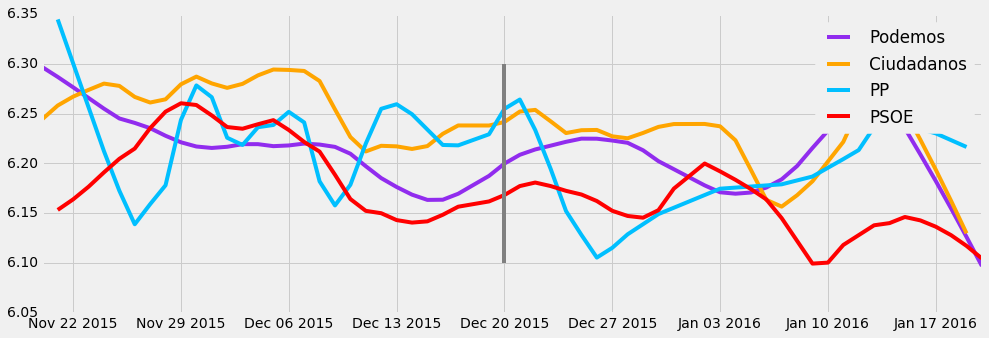

In [44]:
print_points = False
smoothing = 0.2
colors = ["#912CEE","orange","#00BFFF","red"] #Watch out, have 
labels = ["Podemos","Ciudadanos","PP","PSOE"]
plt.figure(figsize=(15,5))
column_ys = "Valence"
column_date = "Date_parsed"

valences  = []
for i,filename in enumerate(filenames): #enumerate gives you the index adn the content of the elements in the list   
    df = pd.read_csv(filename[:-4]+"_formatted.csv",sep=separator_csv,index_col=index_col)
    valences.append(df[column_ys].values)
    if (len(colors) >= len(filenames)) and (len(labels) >= len(filenames) ):
        dates_vs_yvalues(df,column_ys,column_date,groupbyday = True,filter_zeros=True,color=colors[i],smoothing=smoothing,print_points=print_points,label=labels[i])
    else:
        dates_vs_yvalues(df,column_ys,column_date,groupbyday = True,filter_zeros=True,smoothing=smoothing,print_points=print_points)        

compare_samples(valences,parametric=True)
elections = parse("Dec 20, 2015")
plt.plot([elections,elections],[6.1,6.3],color="grey")
plt.legend()
plt.show()

# Classifier
Partially coded
Check: classifier.ipynb

#  Latent Dirichlet Allocation (Semantic analysis)

In [45]:
from matplotlib import cm
import lda
import pylab as plt
from collections import Counter
import bisect
import re
import pickle
import string

#Delete punctuation
def remove_punctuation(string_to_remove):
    transtable = {ord(c): None for c in string.punctuation}
    return string_to_remove.translate(transtable).lower()

def remove_stop_words(text,cached_stop):
    text = ' '.join([word for word in text.lower().split() if word not in cached_stop])
    return text

#Remove endings
def stem_string(string_to_stem,language="english"):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer(language)
    return " ".join([stemmer.stem(word) for word in string_to_stem.split(" ")])

def bi_contains(lst, item):
    """ efficient `item in lst` for sorted lists """
    pos = bisect.bisect_left(lst, item)
    return [((item <= lst[-1]) and (lst[pos] == item)),pos]

def create_dictionary(lang,cached_stop):
    """
    top 5000 words, using labMTsimple
    """
    from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
    labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang=lang,returnVector=True)
    vocab = sorted(list(set(labMTwordList) - set(cached_stop)))
    pickle.dump(vocab,open('./data/vocab.txt',"wb+"))
    
def create_corpus(all_articles,language="english"):
    """
    create the corpus (a numpy array (kind of a list of lists) with the number of times each word appear among all articles)
    """
    vocab = pickle.load(open('./data/vocab.txt',"rb+"))
    len_vocab = len(vocab)
    print("Number of articles: {0}".format(len(all_articles)))
    allMessages = np.zeros((len(all_articles),len_vocab))
    j = -1
    for mess in all_articles:
        mess = remove_stop_words(remove_punctuation(mess),cached_stop)
        j += 1
        # Kind-of efficient way to count words (better to use a dictionary)
        file = re.split(' |\n',mess)
        c = Counter(file)
        del c['']
        values = np.zeros(len_vocab)
        for word in c:
            pos = bi_contains(vocab, word)
            if pos[0]:
                values[pos[1]] = c[word]
        allMessages[j,:] += values
        
    allMessages = np.array(allMessages,dtype=int)
    pickle.dump(allMessages, open('./data/corpus.dat',"wb+"))

def lda_run(allMessages,vocab,topicNum=10,n_iter=1000):
    """
    run lda with allMessages and print topics
    """
    print(topicNum)
    model = lda.LDA(n_topics=topicNum, n_iter=n_iter, random_state=1)
    
    model.fit(allMessages)
    topic_word = model.topic_word_
    print(model.loglikelihood())
    np.savetxt("./data/ldaTopics"+str(topicNum)+".dat",np.asarray(topic_word))
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:]#-[:n_top_words:-1]
        freq_words = np.array(topic_dist)[np.argsort(topic_dist)][:]#-n_top_words:-1]

        print('Topic {}: {}'.format(i, ' '.join(topic_words[::-1][:5])))
        print('Topic {}: {}'.format(i, ' '.join([str(_) for _ in freq_words[::-1][:5]])))


    doc_topic = model.doc_topic_

    allDisSorted = []
    for i in range(allMessages.shape[0]):
        allDisSorted.append(doc_topic[i])

    allDisSorted = np.asarray(allDisSorted)
    np.savetxt("./data/allDistComb1Day"+str(topicNum)+".dat",allDisSorted)
    return model.loglikelihood()
    

def plotNumTopics(x,y,ax2,loglikelihood=False):
    """
    plot points and the smooth line. if KL divergence then divides the results by comb(x,2) to get the mean 
    """
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import pylab as plt
    from scipy.misc import comb
    x = np.asarray(x)
    if loglikelihood:
        y = np.asarray(y)
    else:
        y = np.asarray(y)/comb(x,2)
            
    a = lowess(y,x,frac = 0.3)
    ax2.plot(x,y,'.',linewidth=2,markersize=7,color='orange')

    ax2.plot(x,a[:,1],color='orange',linewidth=2,label='Distance')
    ax2.set_xlabel('Number of Topics',fontsize=12)
    ax2.set_ylabel('Average distance between topic',fontsize=12)



def find_distances(tit="",retTopics = False):
    """
    Finds the distance between topics using:
    (1) the frequency at which each topic appears every day (topics that always appear in the same dates are probably related) 
    (2) the frequency of words appearing in the topics (topics with the same words are probably related)
    """
    from scipy.stats import pearsonr,spearmanr,kendalltau,entropy
    import pylab as plt
    from scipy.spatial.distance import pdist, squareform
    from scipy.cluster.hierarchy import linkage, dendrogram,leaders,fcluster


    def KL_H(u,v):
        return entropy(u,v)*entropy(v,u)/entropy(u)/entropy(v)


    varValues = np.transpose(np.loadtxt("./data/allDistComb1Day"+tit+".dat"))
    data_dist_a = pdist(varValues,lambda u,v: KL_H(u,v))

    varValues2 = (np.loadtxt("./data/ldaTopics"+tit+".dat"))
    data_dist_b = pdist(varValues2,lambda u,v: KL_H(u,v))

    return np.mean(data_dist_a),np.mean(data_dist_b)

def find_number_topics(range_lookup,n_iter=1000):
    """
    iterates through range_lookup and plots the distance between topics, to choose the best number
    
    """
    allMessages =  pickle.load(open('./data/corpus.dat',"rb+"))
    vocab = pickle.load(open('./data/vocab.txt',"rb+"))
        
    distances = []
    for i in range_lookup:
        loglikelihood = lda_run(allMessages,vocab,topicNum = i,n_iter=n_iter)  
        freq_distance, topic_distance = find_distances(tit=str(i),retTopics=True)
        distances.append([loglikelihood,freq_distance,topic_distance])
    
    fig = plt.figure(figsize = (15,5))
    loglikelihood,freq_distance,topic_distance = zip(*distances)
    ax = fig.add_subplot(1,3,1)
    plotNumTopics(range_lookup, loglikelihood,ax,loglikelihood=True)
    ax = fig.add_subplot(1,3,2)
    plotNumTopics(range_lookup, freq_distance,ax,loglikelihood=True)
    ax =fig.add_subplot(1,3,3)
    plotNumTopics(range_lookup, topic_distance,ax,loglikelihood=True)
    plt.show()
    


def correlationMerge(tit="",threshold=0.7):
    """
    Cluster topics that are close (in time and in frequency of words)
    """
    from scipy.stats import pearsonr,spearmanr,kendalltau,entropy
    import pylab as plt
    from scipy.spatial.distance import pdist, squareform
    from scipy.cluster.hierarchy import linkage, dendrogram,leaders,fcluster

    vocab = pickle.load(open('./data/vocab.txt',"rb+"))

    def KL_E(u,v):
        return entropy(u,v)*entropy(v,u)/entropy(u)/entropy(v)

    varValues = np.transpose(np.loadtxt("./data/allDistComb1Day"+str(tit)+".dat"))
    data_dist_a = pdist(varValues,lambda u,v: KL_E(u,v))

    varValues2 = (np.loadtxt("./data/ldaTopics"+str(tit)+".dat"))
    data_dist_b = pdist(varValues2,lambda u,v: KL_E(u,v))
    data_dist = data_dist_a*1 * data_dist_b*1

    #print(data_dist)
    fig = plt.figure(figsize=(8,8))

    # plot first dendrogram:
    ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
    Y = linkage(data_dist, method='weighted') # method?

    t = max(Y[:, 2]) * threshold
    Z1 = dendrogram(Y, orientation='right',
                leaf_font_size=18,color_threshold=t) # adding/removing the axes
                #labels=["Profit","Decay","Profit \n(Ratio)","IMDB rating","Metascore","RottenT \nAudience","RottenT \nCritics","Profit \n(Deviation)"],
    ax1.set_xticks([]) # turn off xticks

    # plot second dendrogram:
    ax2 = fig.add_axes([0.32,0.71,0.58,0.2])
    Z2 = dendrogram(Y,color_threshold=t)
    ax2.set_xticks([])
    ax2.set_yticks([])

    clusters = fcluster(Y,t=t,criterion='distance')
    #print( clusters)
    lisTop = np.asarray(range(len(clusters)))

    #print(np.unique(clusters))
    prov = 0
    for g in np.unique(clusters):
        group = lisTop[clusters==g]
        for i2 in group:
            topic_words = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]
            freq_words = np.array(varValues2[i2,:])[np.argsort(varValues2[i2,:])][:]#-n_top_words:-1]
            prov += np.sum(freq_words[::-1][:10])


    # get the distance matrix:
    D = squareform(data_dist)

    # reorder rows/cols of D to match dendrograms
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    # add matrix
    axmatrix = fig.add_axes([0.32,0.1,0.58,0.6])
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
    plt.colorbar(im, cax=axcolor)
    #plt.savefig("./data/"+'MatrixPrediction'+tit+'.pdf', bbox_inches='tight' ,dpi=100)
    #plt.savefig("./data/"+'MatrixPrediction'+tit+'.png', bbox_inches='tight' ,dpi=100)
    plt.show()
    return clusters,vocab,varValues2

def automatic_annotate(clusters,vocab,varValues2):
    """
    Finds the wods that characterize each cluster (prints them) and by topic (saves them to ./data/topics.csv)
    """
    sumValues = np.sum(varValues2,0)
    lisTop = np.asarray(range(len(clusters)))
    cols = ['g','r','c','b','m','y','k','g','b']
    print(clusters)
    
    for g in np.unique(clusters):
        group = lisTop[clusters==g]
        #print(group)
        prov = np.zeros(len(sumValues))
        for i2 in group:
            topic_words = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]
            freq_words = np.array(varValues2[i2,:])[np.argsort(varValues2[i2,:])][:]#-n_top_words:-1]
            prov += varValues2[i2,:]

            sumValues1 = np.sum(varValues2,0)
  
            topic_words1 = np.array(vocab)[np.argsort(varValues2[i2,:]/sumValues1)][:]#-[:n_top_words:-1]
            sumValues2 = np.ones(len(np.sum(varValues2,0)))
            topic_words2 = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]           
            x = []
            indX = 0
            while len(x) < 20:
                x += list(topic_words1[::-1][indX:indX+1])
                x += list(topic_words2[::-1][indX:indX+1])
                indX += 1
            

            print(i2,' '.join(x))
            #print('Topic {}: {}'.format(i2, ' '.join(topic_words[::-1][:50])))
            #print('Topic {}: {}'.format(i2, ' '.join([str(_) for _ in freq_words[::-1][:50]])))
        sumValues1 = np.sum(varValues2,0)
        topic_words1 = np.array(vocab)[np.argsort(prov/sumValues)][:]#-[:n_top_words:-1]
        sumValues2 = np.ones(len(np.sum(varValues2,0)))
        topic_words2 = np.array(vocab)[np.argsort(prov/sumValues)][:]#-[:n_top_words:-1]
        x = []
        indX = 0
        while len(x) < 20:
            x += list(topic_words1[::-1][indX:indX+1])
            if topic_words2[::-1][indX:indX+1] not in x:
                x += list(topic_words2[::-1][indX:indX+1])
            indX += 1
        
        print("All cluster: ",' '.join(x))
        print("-"*30)
   

    with open("./data/topics.csv","w+") as f:
        for i2 in range(len(clusters)):
        
            topic_words = np.array(vocab)[np.argsort(varValues2[i2,:])][:]#-[:n_top_words:-1]
            freq_words = np.array(varValues2[i2,:])[np.argsort(varValues2[i2,:])][:]#-n_top_words:-1]
         
            sumValues1 = np.sum(varValues2,0)
            topic_words1 = np.array(vocab)[np.argsort(varValues2[i2,:]/sumValues1)][:]#-[:n_top_words:-1]
            sumValues2 = np.ones(len(np.sum(varValues2,0)))
            topic_words2 = np.array(vocab)[np.argsort(varValues2[i2,:]/sumValues2)][:]#-[:n_top_words:-1]
            x = []
            indX = 0
            while len(x) < 30:
                x += list(topic_words1[::-1][indX:indX+1])
                x += list(topic_words2[::-1][indX:indX+1])
                
                indX += 1


            f.write("- {0}\t{1}\n".format(i2,' '.join(x)))

def weightWord(tit="",word='hoi'):
    """
    returns how much weight a word has in every article (based on its topic)
    """
    vocab = pickle.load(open('./data/vocab.txt',"rb"))

    #By day
    varValues = np.transpose(np.loadtxt("./data/allDistComb1Day"+str(tit)+".dat"))
    #By freq
    varValues2 = (np.loadtxt("./data/ldaTopics"+str(tit)+".dat"))

    weigthTopics = np.ones(int(tit))
    
    len_vocab = len(vocab)
    # Kind-of efficient way to count words (better to use a dictionary)
    file = re.split(' |\n',word)
    c = Counter(file)
    del c['']
    values = np.zeros(len_vocab)
    count = 0 
    for word in c:
        pos = bi_contains(vocab, word)
        if pos[0]:
            weigthTopics += np.log10(varValues2[:,pos[1]]/np.sum(varValues2[:,pos[1]])*c[word])
            

    weigthTopics = (weigthTopics - np.min(weigthTopics))
    weigthTopics /= np.sum(weigthTopics)
    
    return weigthTopics

    
def plot_imshows(all_topics,filenames,num_topics):
    """
    given all_topics = 2D array, one dimension = topics, the other = different queries we are comparing
    """
    all_topics[all_topics==0] = np.NaN

    plt.figure(figsize = (15,10))
    plt.subplot(2,1,1)
    plt.imshow(all_topics*10,interpolation="none",aspect="auto",cmap=plt.cm.YlGnBu)
    plt.yticks(range(len(filenames)),[_[_.find("a/")+2:_.find(".csv")] for _ in filenames])
    plt.xticks(range(num_topics),[str(_) for _ in range(num_topics)])
    plt.grid(False)
    plt.colorbar()
    plt.title("Not normalized")
    for topic_number in range(num_topics):
        all_topics[:,topic_number] = (all_topics[:,topic_number] - np.mean(all_topics[:,topic_number]))/np.std(all_topics[:,topic_number])

    plt.subplot(2,1,2)
    plt.title("Normalized")
    plt.imshow(all_topics,interpolation="none",aspect="auto", cmap=plt.cm.YlGnBu)
    plt.yticks(range(len(filenames)),[_[_.find("a/")+2:_.find(".csv")] for _ in filenames])
    plt.xticks(range(num_topics),[str(_) for _ in range(num_topics)])
    plt.grid(False)
    plt.colorbar()
    plt.show()

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
separator_csv = "\t" #tab
header = None
index_col = None 
columns_csv = ["Date","Newspaper","Article"]
column_text = "Article" #leave empty to not get the valence
column_date = "Date" #leave empty to not parse the date
language = "spanish"
filenames = ["./data/Pablo_Iglesias_Podemos.csv","./data/Albert_Rivera_Ciudadanos.csv","./data/Mariano_Rajoy_PP.csv","./data/Pedro_Sanchez_PSOE.csv"]

## Put all the articles together
all_messages = []
## Fill up
for filename in filenames:
    print(filename)
    df = pd.read_csv(filename,sep=separator_csv,header=header,index_col=index_col)
    df.columns = columns_csv
    all_messages = all_messages + [article for article in df[column_text].values]
    
extra_stop_words = [_.lower() for _ in ["elpais.com","elpais","Podemos","Pablo","Iglesias","Ciudadanos","Albert","Rivera","Pedro","Sanchez","Sánchez","PSOE","Mariano","Rajoy","PP"]]
cached_stop = set(stopwords.words(language) + extra_stop_words)

## Create dictionary with words 
create_dictionary(lang=language, cached_stop=cached_stop)

## Create corpus (counts words for every article)
create_corpus(all_messages,language=language)


In [ ]:
## Tof ind the number of topics. Start with a large range and low number of iterations. SLOW
find_number_topics(range(2,100,10),n_iter=100)

In [ ]:
## Tof ind the number of topics. Narrow the range and middle number of iterations. SLOW
find_number_topics(range(5,50,2),n_iter=1000)

In [ ]:
## Settle to some number of topics. SLOW
find_number_topics([20],n_iter=10000)

In [ ]:
## Cluster topics
clusters,vocab,varValues2 = correlationMerge(20,threshold=0.6)

In [ ]:
## Tells you what every cluster is about, and save the words in every topic to a file ./data/topics.csv
automatic_annotate(clusters,vocab,varValues2)

In [ ]:
## Returns of the word weight by day
weightWord(20,word="prisión")

In [ ]:
## Plots what topics are important for the different data sets

import pandas as pd
import re
from nltk.corpus import stopwords
filenames = ["./data/Pablo_Iglesias_Podemos.csv","./data/Albert_Rivera_Ciudadanos.csv","./data/Mariano_Rajoy_PP.csv","./data/Pedro_Sanchez_PSOE.csv"]

separator_csv = "\t" #tab
header = None
index_col = None 
columns_csv = ["Date","Newspaper","Article"]
column_text = "Article" #leave empty to not get the valence
column_date = "Date" #leave empty to not parse the date
language = "spanish"
extra_stop_words = [_.lower() for _ in ["elpais.com","elpais","Podemos","Pablo","Iglesias","Ciudadanos","Albert","Rivera","Pedro","Sanchez","Sánchez","PSOE","Mariano","Rajoy","PP"]]

cached_stop = set(stopwords.words(language) + extra_stop_words)
num_topics = 20

all_topics = np.zeros((len(filenames),num_topics))
## Fill up
for i,filename in enumerate(filenames):
    print(filename)
    df = pd.read_csv(filename,sep=separator_csv,header=header,index_col=index_col)
    df.columns = columns_csv
    all_messages =  " ".join(df["Article"].values)
    mess = remove_stop_words(remove_punctuation(all_messages),cached_stop)
    all_topics[i,:] = weightWord(num_topics,word=mess)
    print(all_topics[i,:])

plot_imshows(all_topics,filenames,num_topics)